In [1]:
# deutsch_jozsa.ipynb
# solves a similar problem to deutsch algorithm (secret function applied on two qubits)

# Cell 1 - Implement Deutsch-Jozsa Oracle with pure linear algebra

import numpy as np

# initialize q0 and q1
q_0 = np.array([1, 0], dtype=complex)  # basis |0> state
q_1 = np.array([0, 1], dtype=complex)  # basis |1> state

g_I = np.array([[1, 0], [0, 1]], dtype=complex)  # identity
g_H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)  # hadamard gate
g_H2 = np.kron(
    g_H, g_H
)  # tensor of the hadamard gate: can be applied to a two qubit register
g_H_I = np.kron(
    g_H2, g_I
)  # operator that applies the hadamard to the first qubit of a two qubit register
# and the identity to the second qubit of a two qubit register


def deutsch_jozsa(u_f):
    # x is a tw-qubit register and y is an independent qubit
    x = np.kron(q_0, q_0)  # tensor two |0> qubits together
    y = np.copy(q_1)  # one |1> qubit

    g1 = np.dot(g_H2, x)  # hadamard gate on x
    g2 = np.dot(g_H, y)  # hadamard gate on y
    # now, x and y are both in superpositions

    t1 = np.kron(g1, g2)  # measurement of x and y after hadamard gates
    t2 = np.dot(u_f, t1)  # u_f: "hidden" function applied to the tensor
    # of x and y after they have been modified with the hadamard gates

    g4 = np.dot(
        t2, g_H_I
    )  # apply the hadamard gate on x and the identity on y: measure

    # if the final tensor state vector is of the form: [x,0,0,0,0,0,0,0], then the function is constant
    # otherwise, the function is balanced
    if np.isclose(g4[2:], 0).all():
        print("Constant")
    else:
        print("Balanced")


# test this "secret" balanced function

u_f1 = np.zeros((8, 8), dtype=complex)
u_f1[0, 1] = u_f1[1, 0] = u_f1[2, 3] = u_f1[3, 2] = 1
u_f1[4, 4] = u_f1[5, 5] = u_f1[6, 6] = u_f1[7, 7] = 1

deutsch_jozsa(u_f1)

# test this "secret" constant function:
u_f2 = np.zeros((8, 8), dtype=complex)
u_f2[0, 1] = u_f2[1, 0] = u_f2[2, 3] = u_f2[3, 2] = 1
u_f2[4, 5] = u_f2[5, 4] = u_f2[6, 7] = u_f2[7, 6] = 1

deutsch_jozsa(u_f2)


Balanced
Constant


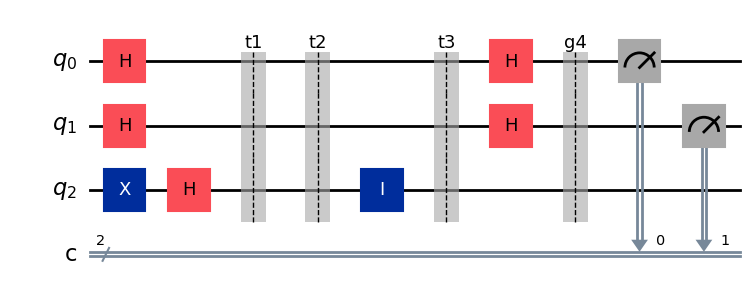

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

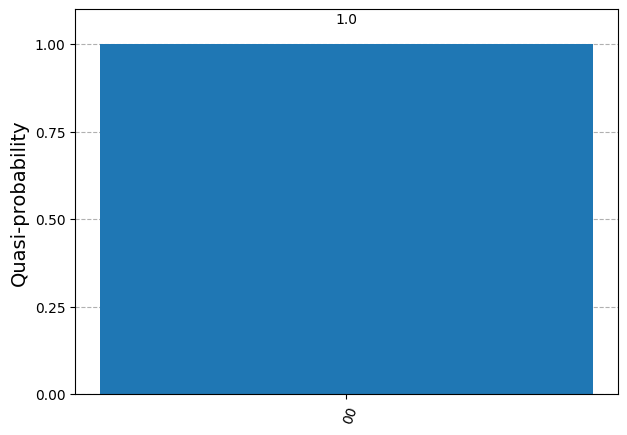

In [24]:
# Cell 2: implement Deutsch-Jozsa with Qiskit: display the circuit
# test on NOP; should return balanced (measurement of 00)
import numpy as np
from IPython.display import display
from qis102_utils import as_latex
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import (
    plot_distribution,
)
from qiskit_aer import AerSimulator

# set n: number of qubits in the n-qubit register
n = 2
# create a quantum register initialized to 0
# this is an n-qubit register for "querying" the oracle, with one qubit for storing the answer
# include one classical bit so as to measure the answer
qc = QuantumCircuit(n + 1, n)

# create a superposition of all of the qubits in the n-qubit register by applying the hadamard gate
for i in range(n):
    qc.h(i)

# flip the second register and apply the hadamard gate
qc.x(n)  # this is so that the last qubit is in the |1> state (y from before)
qc.h(n)  # places this qubit in a superposition by applying the hadamard gate

qc.save_statevector("t1")  # this is the same as "t1" from Cell-1

# INSERT "secret" function here: NOP (no change = no need for function)

qc.save_statevector("t2")  # this is the same as "t2" from Cell-1
qc.id(n)  # apply the identity to the final qubit ("y")
qc.save_statevector("t3")
# apply hadamard gates to the "x" register
for i in range(n):
    qc.h(i)
qc.save_statevector("g4")
# measure:
for i in range(n):
    qc.measure(i, i)

# Now run the circuit on the device and display necessary information
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled).result()

t1 = result.data(0)["t1"]
t2 = result.data(0)["t2"]
t3 = result.data(0)["t3"]
g4 = result.data(0)["g4"]

g4_array = np.array(g4)

display(qc.draw(output="mpl"))
counts = result.get_counts(qc)

display(as_latex(t1, prefix=r"\mathbf{t1}="))
display(as_latex(t2, prefix=r"\mathbf{t2}="))
display(as_latex(g4, prefix=r"\mathbf{t3}="))


display(plot_distribution(counts))

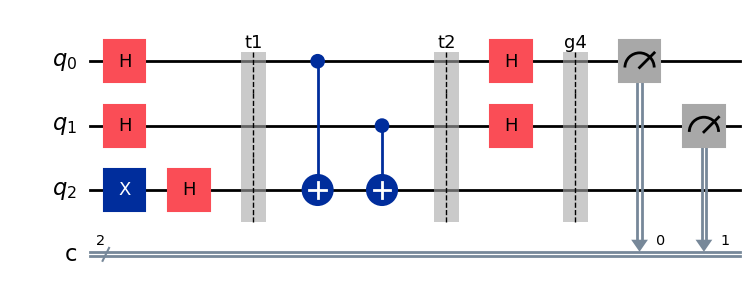

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

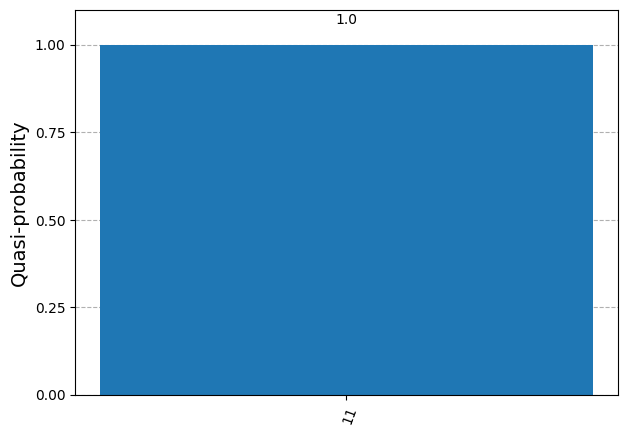

In [26]:
# Cell 3: implement Deutsch-Jozsa with Qiskit: display the circuit
# test on Always 0; should return constant (measurement of 11)
import numpy as np
from IPython.display import display
from qis102_utils import as_latex
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import (
    plot_distribution,
)
from qiskit_aer import AerSimulator

# set n: number of qubits in the n-qubit register
n = 2
# create a quantum register initialized to 0
# this is an n-qubit register for "querying" the oracle, with one qubit for storing the answer
# include one classical bit so as to measure the answer
qc = QuantumCircuit(n + 1, n)

# create a superposition of all of the qubits in the n-qubit register by applying the hadamard gate
for i in range(n):
    qc.h(i)

# flip the second register and apply the hadamard gate
qc.x(n)  # this is so that the last qubit is in the |1> state (y from before)
qc.h(n)  # places this qubit in a superposition by applying the hadamard gate

qc.save_statevector("t1")  # this is the same as "t1" from Cell-1

# INSERT "secret" function here:
# always zero (apply CNOT gates on the qubits of "x")
for i in range(n):
    if 1 << i:
        qc.cx(i, n)

qc.save_statevector("t2")  # this is the same as "t2" from Cell-1

# apply hadamard gates to the "x" register
for i in range(n):
    qc.h(i)
qc.save_statevector("g4")
# measure:
for i in range(n):
    qc.measure(i, i)

# Now run the circuit on the device and display necessary information
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled).result()

t1 = result.data(0)["t1"]
t2 = result.data(0)["t2"]
g4 = result.data(0)["g4"]

g4_array = np.array(g4)

display(qc.draw(output="mpl"))
counts = result.get_counts(qc)

display(as_latex(t1, prefix=r"\mathbf{t1}="))
display(as_latex(t2, prefix=r"\mathbf{t2}="))
display(as_latex(g4, prefix=r"\mathbf{t3}="))


display(plot_distribution(counts))
